# Tutorial: ECT for example dataset

<div>
<img src="images/graphECTgif.gif" width="800" align='center'/>
</div>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path

# Only for testing purposes
from sys import path
path.append( "../../ect/ect" )
from ect import ECT, EmbeddedGraph


We are using a subset of the leaf shape dataset from [(Li et al., 2018)](https://www.frontiersin.org/journals/plant-science/articles/10.3389/fpls.2018.00553/full) as an example in this tutorial. Samples in the dataset are coordinates $(x,y)\in\mathbb{R}^2$ that form outlines of leaves. The data is pre-centered and scaled to account for any sampling resolution differences between leaf samples.
In the published version of the dataset, these coordinates are not ordered, however in order to represent the leaf outlines as a graph, we require the coordinates be ordered such that the outline of each leaf can be traced out by the graph representation.
To address the lack of ordering of the coordinates, we use the dataset version from [(Wiley, 2023)](https://github.com/willeyna/ECT\_of\_leaves), in which they use $2$-nearest neighbor graphs to order all coordinates so as to trace the outline of each leaf.

Using coordinates for each leaf, ordered such that connecting subsequent coordinates in forms the leaf outline, we build a graph representation of each leaf sample. Each of the coordinates of the leaf are represented as vertices in the graph, with edges between vertices that are adjacent in the leaf outline and the graph embedding defined by the coordinates $(x,y)\in\mathbb{R}^2$ for each vertex. Here is an example of the graph representation for this dataset from the Cotton class, zoomed in (right, in red) to show graph structure and the subgraph highlighted in red on the full outline graph.

<div>
<img src="images/Cotton_full.png" width="400" align='center'/>
<img src="images/Cotton_zoom.png" width="400" align='center'/>
</div>

# Load in the leaf dataset
- This is a subset of the full dataset provided in [(Li et al., 2018)](https://www.frontiersin.org/journals/plant-science/articles/10.3389/fpls.2018.00553/full), with two classes (Cotton and Ivy) selected, each containing $30$ leaf outline samples.
- The ECT of each leaf sample is computed and saved as a .npy file in a directory structure matching the original dataset.


### Here is an example loading a single leaf sample, computing the ECT, and saving the output matrix.

First define the filename of the sample to be loaded and use `np.load()` to load in the numpy file.

In [2]:
input_filedir = 'example_data/outline_input/Cotton/1a_868a.npy'
output_filedir = 'example_data/ect_output/Cotton/1a_868a.npy'
leaf = np.load(input_filedir)

Next, we initalize a graph object for the leaf sample.

In [3]:
G = EmbeddedGraph()

Use coordinates of the leaf outline points to add vertices (and embedding coordinates) to the graph object.

In [4]:
valuesX = leaf[:,0]
valuesY = leaf[:,1]
for i in range(np.shape(leaf)[0]):
    G.add_node(i,valuesX[i],valuesY[i])

Add edges to the graph according to the outline order. The samples of this dataset all have coordinates listed in order of the outline of the leaf. Note that for other datasets where this isn't the case, a different method must be used to define the graph structure.

<Axes: >

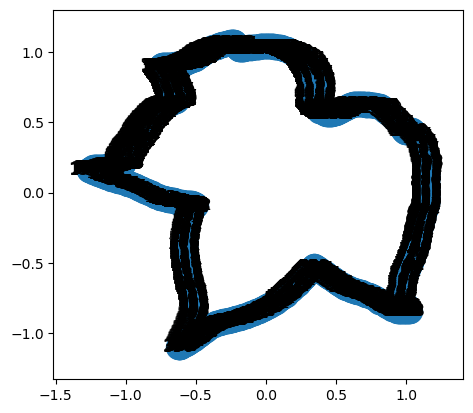

In [5]:
for i in range(np.shape(leaf)[0]-1):
    G.add_edge(i, i+1)
G.add_edge(0,np.shape(leaf)[0]-1)

G.plot()

Now, we initialize the ECT object using $32$ directions and $48$ thresholds.

In [6]:
num_dirs = 101
num_thresh = 101

myect = ECT(num_dirs = num_dirs, num_thresh = num_thresh)
print(f'Directions chosen are: {myect.thetas}')

Directions chosen are: [0.         0.06220976 0.12441951 0.18662927 0.24883902 0.31104878
 0.37325853 0.43546829 0.49767804 0.5598878  0.62209756 0.68430731
 0.74651707 0.80872682 0.87093658 0.93314633 0.99535609 1.05756584
 1.1197756  1.18198535 1.24419511 1.30640487 1.36861462 1.43082438
 1.49303413 1.55524389 1.61745364 1.6796634  1.74187315 1.80408291
 1.86629267 1.92850242 1.99071218 2.05292193 2.11513169 2.17734144
 2.2395512  2.30176095 2.36397071 2.42618047 2.48839022 2.55059998
 2.61280973 2.67501949 2.73722924 2.799439   2.86164875 2.92385851
 2.98606826 3.04827802 3.11048778 3.17269753 3.23490729 3.29711704
 3.3593268  3.42153655 3.48374631 3.54595606 3.60816582 3.67037558
 3.73258533 3.79479509 3.85700484 3.9192146  3.98142435 4.04363411
 4.10584386 4.16805362 4.23026338 4.29247313 4.35468289 4.41689264
 4.4791024  4.54131215 4.60352191 4.66573166 4.72794142 4.79015117
 4.85236093 4.91457069 4.97678044 5.0389902  5.10119995 5.16340971
 5.22561946 5.28782922 5.35003897 5.412

Set the bounding radius to be the global dataset bounding radius, so we can use the same bounding radius for all samples of the dataset.
<div>
<img src="images/boundingbox.png" width="400"/>
</div>

**[TO DO:]** compute the dataset global radius within ect package functionality


In [7]:
global_bound_radius = 2.9092515639765497 
myect.set_bounding_radius(global_bound_radius)
print(f'Set radius is: {myect.bound_radius}')

Set radius is: 2.9092515639765497


Now the thresholds are set.

In [8]:
print(f'Thresholds chosen are: {myect.threshes}')

Thresholds chosen are: [-2.90925156 -2.85106653 -2.7928815  -2.73469647 -2.67651144 -2.61832641
 -2.56014138 -2.50195635 -2.44377131 -2.38558628 -2.32740125 -2.26921622
 -2.21103119 -2.15284616 -2.09466113 -2.03647609 -1.97829106 -1.92010603
 -1.861921   -1.80373597 -1.74555094 -1.68736591 -1.62918088 -1.57099584
 -1.51281081 -1.45462578 -1.39644075 -1.33825572 -1.28007069 -1.22188566
 -1.16370063 -1.10551559 -1.04733056 -0.98914553 -0.9309605  -0.87277547
 -0.81459044 -0.75640541 -0.69822038 -0.64003534 -0.58185031 -0.52366528
 -0.46548025 -0.40729522 -0.34911019 -0.29092516 -0.23274013 -0.17455509
 -0.11637006 -0.05818503  0.          0.05818503  0.11637006  0.17455509
  0.23274013  0.29092516  0.34911019  0.40729522  0.46548025  0.52366528
  0.58185031  0.64003534  0.69822038  0.75640541  0.81459044  0.87277547
  0.9309605   0.98914553  1.04733056  1.10551559  1.16370063  1.22188566
  1.28007069  1.33825572  1.39644075  1.45462578  1.51281081  1.57099584
  1.62918088  1.68736591  1.

Next, we calculate the ECT using the directions and thresholds specified by myect object.

In [9]:
print(myect.calculateECT(G))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Now we can access the saved ECT matrix and optionally plot the ECT image or save the matrix as a numpy file.

M has shape: (101, 101)
Saving the ECT of sample as: example_data/ect_output/Cotton/1a_868a.npy ...


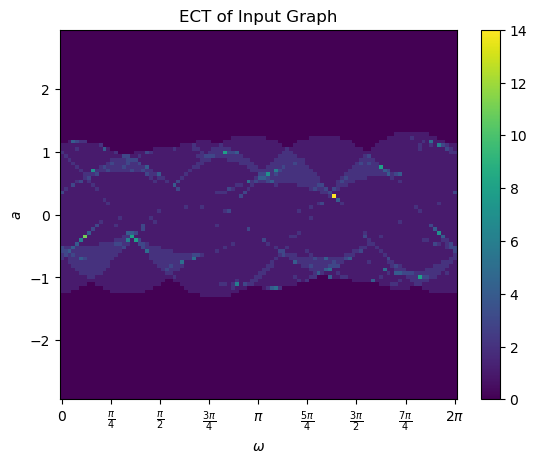

In [10]:
# The saved ECT matrix
M = myect.get_ECT()
print(f'M has shape: {M.shape}')

myect.plot('ECT')

# save the ECT matrix as a numpy file
Path(os.path.dirname(output_filedir)).mkdir(parents=True, exist_ok=True)
print(f'Saving the ECT of sample as: {output_filedir} ...')
np.save(output_filedir, M)

### Now perform the same  process on all of the samples of the dataset, computing the ECT, and saving the output matrix.

In [11]:
mypath = 'example_data/outline_input/'
mypath_output = 'example_data/ect_output/'


# loop through file system
classes=[]
class_count = 0
for path, subdirs, files in os.walk(mypath):
    classes.extend(subdirs)
    files = [f for f in files if not f[0] == '.']
    subdirs[:] = [d for d in subdirs if (d[0] != '.')]
    print('Computing ECT of files in ', path, '...')
    print("There are ",len(files), ' samples to load in this directory.')
    
    for name in files:
        input_filedir = os.path.join(path, name)
        leaf = np.load(input_filedir)
        
        # Define a graph object for the leaf
        G = EmbeddedGraph()

        # Use coordinates of the leaf outline points to add vertices (and embedding coordinates) to the graph object
        valuesX = leaf[:,0]
        valuesY = leaf[:,1]
        for i in range(np.shape(leaf)[0]):
            G.add_node(i,valuesX[i],valuesY[i])

        # Add edges to the graph according to the outline order
        for i in range(np.shape(leaf)[0]-1):
            G.add_edge(i, i+1)
        G.add_edge(0,np.shape(leaf)[0]-1)
        
        # initialize the ECT object using 32 directions and 48 thresholds
        myect = ECT(num_dirs = num_dirs, num_thresh = num_thresh)

        # Set the bounding radius to be the global dataset bounding radius
        # TO DO: compute the dataset global radius within ect package
        global_bound_radius = 2.9092515639765497
        myect.set_bounding_radius(global_bound_radius)

        myect.calculateECT(G)

        # The saved ECT matrix
        M = myect.get_ECT()


        # save the ECT matrix as a numpy file
        output_filedir = os.path.join(mypath_output+ input_filedir[len(mypath):])
        Path(os.path.dirname(output_filedir)).mkdir(parents=True, exist_ok=True)
        np.save(output_filedir, M)
        
        
    print('Saving the ECT of directory in ', path, '...')


Computing ECT of files in  example_data/outline_input/ ...
There are  0  samples to load in this directory.
Saving the ECT of directory in  example_data/outline_input/ ...
Computing ECT of files in  example_data/outline_input/Cotton ...
There are  30  samples to load in this directory.
Saving the ECT of directory in  example_data/outline_input/Cotton ...
Computing ECT of files in  example_data/outline_input/Ivy ...
There are  30  samples to load in this directory.
Saving the ECT of directory in  example_data/outline_input/Ivy ...


Now we have a saved dataset consisting of ECT matrices for the leaf outline dataset. We can train various models using these ECT matrices. Here, we show an example using a Convolutional Neural Network (CNN) to perform binary classification between the "Cotton" and "Ivy" classes.

# Train a CNN model on the ECT images

In [12]:
import torch
import argparse
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm

c:\Users\manki\miniconda3\envs\pytorch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


This is the CNN model class we will use for classification, defined in `models.py`. Within this class, we specify the kernel size parameter. 
<div>
<img src="images/cnn_architecture.png" width="1000"/>
</div>

Also within `models.py`, the CNN class is defined using cylinder padding scheme for both of the convolution layers. To facilitate the illusion that the input images are cylindrical, we use padding defined by built in methods as part of the PyTorch package.
For each of the sides, where we want the left edge to be identified with the right edge of the image, we use circular padding which uses copies of columns from the right side to pad the left and copies of the left side to pad the right. On the top and bottom of each image, we pad with zero-valued pixels, which is a standard choice for computer vision tasks.
<div>
<img src="images/cylinder_and_zero_padding.jpeg" width="500"/>
</div>

In [13]:
from models import CNN

These functions allow us to define datasets and load them into PyTorch. The dataset classes and data loaders can be adjusted in `dataloaders.py`.

In [14]:
from dataloaders import create_datasets, create_data_loaders
from utils import save_model, save_plots, save_cf, SaveBestModel

Here we define a few model training parameters: the number of epochs to train the model and the learning rate. We also use a batch size of 4 samples, which is defined in `dataloaders.py`.

In [15]:
NUM_EPOCHS = 50 # number of epochs to train the network for; type=int
LEARNING_RATE = 1e-3 # learning rate for training; type=float

In [16]:
# device
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

Computation device: cuda



### Load in the dataset and split into training and test datasets

Next, we build the training and test datasets as well as the dataloaders for each.

In [17]:
train_dataset, test_dataset = create_datasets()

train_loader, test_loader = create_data_loaders(train_dataset, test_dataset)

c:\Users\manki\OneDrive - Michigan State University\ECT-Dan Chitwood\ECT-Leaf-CNN\leaf-example-tutorial/example_data/ect_output/
['Cotton', 'Ivy']
num_classes= 2
ECT data; using only normalize, rotation transforms on training data


Now, show a few samples from the training dataset. The labels for this example batch are printed as the title of each, where 0 indicates Ivy and 1 indicates Cotton'

In [18]:
trainimages, trainlabels = next(iter(train_loader))
print(f'The tensor shape of each batch in the training dataset is \n[batch_size, num_channels, num_directions, num_thresholds]: {trainimages.shape}')

The tensor shape of each batch in the training dataset is 
[batch_size, num_channels, num_directions, num_thresholds]: torch.Size([4, 1, 101, 101])


training images


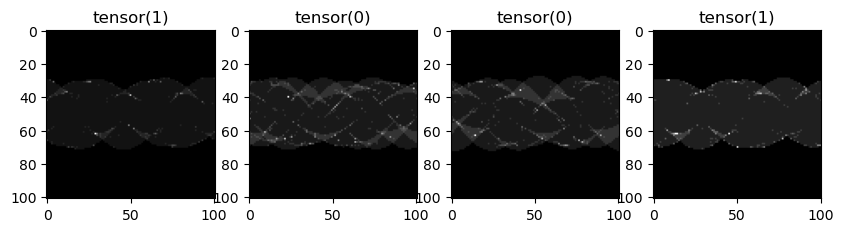

In [19]:
plt.style.use('default')
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
print('training images')
for i in range(4):
    ax = axes[i]
    ax.imshow(trainimages[i,0,:,:].T, cmap='gray')
    ax.set_title(trainlabels[i])
plt.show()

Next, we define two functions: `train()` and `validate()`. These define the training scheme and keep track of the loss during training (and validation) as well as the model accuracy.

In [20]:
def train(model, train_loader, optimizer, lossfcn):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(train_loader), total=len(train_loader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # forward pass
        outputs = model(image)
        # calculate the loss
        loss = lossfcn(outputs, labels)
        train_running_loss += loss.item()
        # calculate the accuracy
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # backpropagation
        loss.backward()
        # update the optimizer parameters
        optimizer.step()
    
    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(train_loader.dataset))
    return epoch_loss, epoch_acc

In [21]:
# function for validation
def validate(model, valid_loader, lossfcn):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        outputs_list = []
        labels_list = []
        for i, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # forward pass
            outputs = model(image)
            outputs_list.append(outputs)
            labels_list.append(labels)
            # calculate the loss
            loss = lossfcn(outputs, labels)
            valid_running_loss += loss.item()
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
        
    # loss and accuracy for the complete epoch
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(valid_loader.dataset))

    return epoch_loss, epoch_acc

Here, we specify the model to be used for training and print out a summary of the layers in the model.

In [22]:
model = CNN(num_classes=train_dataset.num_classes, num_channels=trainimages.shape[1],input_resolution=(num_dirs,num_thresh)).to(device)
print(model)

CNN(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=12500, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=2, bias=True)
)


We can also print out the total number of parameters and trainable parameters for the model for reference.

In [23]:
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.\n")

12,804,994 total parameters.
12,804,994 training parameters.



Next, we specifify the optimizer and loss function to be used for training. In this case we use the Adam optimizer built into PyTorch, which uses a gradient descent algorithm. We use a cross entropy loss function built into PyTorch, which computes the difference between two probability distributions and outputs a score (between 0 and 1, where 0 is a perfect score) summarizing the average difference between the predicted and actual values during training.

In [24]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-3)
# loss function
lossfcn = nn.CrossEntropyLoss()
# initialize SaveBestModel class
save_best_model = SaveBestModel()

Now we actually train the model using our previously defined `train()` function! During training, we keep track of overall loss and accuracy values so that we can plot the behavior of the model throughout training.

In [25]:
train_loss, valid_loss = [],[]
train_acc, valid_acc = [],[]

# begin training
for epoch in range(1,NUM_EPOCHS+1):
    print(f"[INFO]: Epoch {epoch} of {NUM_EPOCHS}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader, optimizer, lossfcn)
    valid_epoch_loss, valid_epoch_acc = validate(model, test_loader, lossfcn)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")

    # save the best model up to current epoch, if we have the least loss in the current epoch
    save_best_model(
        valid_epoch_loss, epoch, model, optimizer, lossfcn
    )
    print('-'*50)
    

[INFO]: Epoch 1 of 50
Training


100%|██████████| 12/12 [00:00<00:00, 14.63it/s]


Validation


100%|██████████| 3/3 [00:00<00:00, 299.87it/s]


Training loss: 2.165, training acc: 52.083
Validation loss: 0.680, validation acc: 58.333

Best validation loss: 0.6804627577463785

Saving best model for epoch: 1

--------------------------------------------------
[INFO]: Epoch 2 of 50
Training


100%|██████████| 12/12 [00:00<00:00, 101.68it/s]


Validation


100%|██████████| 3/3 [00:00<00:00, 249.93it/s]


Training loss: 1.005, training acc: 41.667
Validation loss: 0.707, validation acc: 41.667
--------------------------------------------------
[INFO]: Epoch 3 of 50
Training


100%|██████████| 12/12 [00:00<00:00, 100.72it/s]


Validation


100%|██████████| 3/3 [00:00<00:00, 272.88it/s]


Training loss: 0.822, training acc: 41.667
Validation loss: 0.683, validation acc: 58.333
--------------------------------------------------
[INFO]: Epoch 4 of 50
Training


100%|██████████| 12/12 [00:00<00:00, 97.93it/s]


Validation


100%|██████████| 3/3 [00:00<00:00, 314.36it/s]


Training loss: 0.703, training acc: 45.833
Validation loss: 0.709, validation acc: 41.667
--------------------------------------------------
[INFO]: Epoch 5 of 50
Training


100%|██████████| 12/12 [00:00<00:00, 100.40it/s]


Validation


100%|██████████| 3/3 [00:00<00:00, 272.87it/s]


Training loss: 0.633, training acc: 60.417
Validation loss: 0.682, validation acc: 66.667
--------------------------------------------------
[INFO]: Epoch 6 of 50
Training


100%|██████████| 12/12 [00:00<00:00, 101.25it/s]


Validation


100%|██████████| 3/3 [00:00<00:00, 299.82it/s]


Training loss: 0.769, training acc: 50.000
Validation loss: 0.659, validation acc: 66.667

Best validation loss: 0.6586363911628723

Saving best model for epoch: 6

--------------------------------------------------
[INFO]: Epoch 7 of 50
Training


100%|██████████| 12/12 [00:00<00:00, 99.05it/s]


Validation


100%|██████████| 3/3 [00:00<00:00, 272.76it/s]

Training loss: 0.654, training acc: 54.167
Validation loss: 0.640, validation acc: 66.667

Best validation loss: 0.6402710874875387

Saving best model for epoch: 7



--------------------------------------------------
[INFO]: Epoch 8 of 50
Training


100%|██████████| 12/12 [00:00<00:00, 101.17it/s]


Validation


100%|██████████| 3/3 [00:00<00:00, 300.05it/s]

Training loss: 0.581, training acc: 64.583
Validation loss: 0.601, validation acc: 75.000

Best validation loss: 0.601022481918335

Saving best model for epoch: 8



--------------------------------------------------
[INFO]: Epoch 9 of 50
Training


100%|██████████| 12/12 [00:00<00:00, 96.75it/s]


Validation


100%|██████████| 3/3 [00:00<00:00, 250.01it/s]


Training loss: 0.700, training acc: 62.500
Validation loss: 0.614, validation acc: 58.333
--------------------------------------------------
[INFO]: Epoch 10 of 50
Training


100%|██████████| 12/12 [00:00<00:00, 100.16it/s]


Validation


100%|██████████| 3/3 [00:00<00:00, 297.64it/s]


Training loss: 0.657, training acc: 64.583
Validation loss: 0.636, validation acc: 58.333
--------------------------------------------------
[INFO]: Epoch 11 of 50
Training


100%|██████████| 12/12 [00:00<00:00, 100.57it/s]


Validation


100%|██████████| 3/3 [00:00<00:00, 269.41it/s]


Training loss: 0.503, training acc: 81.250
Validation loss: 0.500, validation acc: 75.000

Best validation loss: 0.5003805061181387

Saving best model for epoch: 11

--------------------------------------------------
[INFO]: Epoch 12 of 50
Training


100%|██████████| 12/12 [00:00<00:00, 103.16it/s]


Validation


100%|██████████| 3/3 [00:00<00:00, 272.78it/s]

Training loss: 0.439, training acc: 79.167
Validation loss: 0.379, validation acc: 83.333

Best validation loss: 0.3791476438442866

Saving best model for epoch: 12



--------------------------------------------------
[INFO]: Epoch 13 of 50
Training


100%|██████████| 12/12 [00:00<00:00, 102.53it/s]


Validation


100%|██████████| 3/3 [00:00<00:00, 270.72it/s]


Training loss: 0.343, training acc: 83.333
Validation loss: 0.400, validation acc: 83.333
--------------------------------------------------
[INFO]: Epoch 14 of 50
Training


100%|██████████| 12/12 [00:00<00:00, 99.84it/s]


Validation


100%|██████████| 3/3 [00:00<00:00, 297.10it/s]


Training loss: 0.288, training acc: 91.667
Validation loss: 0.299, validation acc: 83.333

Best validation loss: 0.2986174449324608

Saving best model for epoch: 14

--------------------------------------------------
[INFO]: Epoch 15 of 50
Training


100%|██████████| 12/12 [00:00<00:00, 100.20it/s]


Validation


100%|██████████| 3/3 [00:00<00:00, 272.64it/s]

Training loss: 0.186, training acc: 93.750
Validation loss: 0.258, validation acc: 91.667

Best validation loss: 0.2579166665673256

Saving best model for epoch: 15



--------------------------------------------------
[INFO]: Epoch 16 of 50
Training


100%|██████████| 12/12 [00:00<00:00, 100.71it/s]


Validation


100%|██████████| 3/3 [00:00<00:00, 272.67it/s]


Training loss: 0.152, training acc: 97.917
Validation loss: 0.313, validation acc: 75.000
--------------------------------------------------
[INFO]: Epoch 17 of 50
Training


100%|██████████| 12/12 [00:00<00:00, 100.11it/s]


Validation


100%|██████████| 3/3 [00:00<00:00, 249.53it/s]


Training loss: 0.259, training acc: 93.750
Validation loss: 0.365, validation acc: 83.333
--------------------------------------------------
[INFO]: Epoch 18 of 50
Training


100%|██████████| 12/12 [00:00<00:00, 100.81it/s]


Validation


100%|██████████| 3/3 [00:00<00:00, 296.65it/s]


Training loss: 0.253, training acc: 91.667
Validation loss: 0.313, validation acc: 83.333
--------------------------------------------------
[INFO]: Epoch 19 of 50
Training


100%|██████████| 12/12 [00:00<00:00, 97.40it/s]


Validation


100%|██████████| 3/3 [00:00<00:00, 272.60it/s]


Training loss: 0.185, training acc: 89.583
Validation loss: 0.220, validation acc: 83.333

Best validation loss: 0.21973898587748408

Saving best model for epoch: 19

--------------------------------------------------
[INFO]: Epoch 20 of 50
Training


100%|██████████| 12/12 [00:00<00:00, 102.13it/s]


Validation


100%|██████████| 3/3 [00:00<00:00, 269.57it/s]

Training loss: 0.183, training acc: 91.667
Validation loss: 0.131, validation acc: 91.667

Best validation loss: 0.13082729171340665

Saving best model for epoch: 20



--------------------------------------------------
[INFO]: Epoch 21 of 50
Training


100%|██████████| 12/12 [00:00<00:00, 100.05it/s]


Validation


100%|██████████| 3/3 [00:00<00:00, 299.36it/s]

Training loss: 0.137, training acc: 97.917
Validation loss: 0.117, validation acc: 100.000

Best validation loss: 0.11737734451889992

Saving best model for epoch: 21



--------------------------------------------------
[INFO]: Epoch 22 of 50
Training


100%|██████████| 12/12 [00:00<00:00, 95.19it/s]


Validation


100%|██████████| 3/3 [00:00<00:00, 333.99it/s]


Training loss: 0.156, training acc: 91.667
Validation loss: 0.175, validation acc: 83.333
--------------------------------------------------
[INFO]: Epoch 23 of 50
Training


100%|██████████| 12/12 [00:00<00:00, 97.60it/s]


Validation


100%|██████████| 3/3 [00:00<00:00, 300.74it/s]


Training loss: 0.091, training acc: 97.917
Validation loss: 0.156, validation acc: 91.667
--------------------------------------------------
[INFO]: Epoch 24 of 50
Training


100%|██████████| 12/12 [00:00<00:00, 100.86it/s]


Validation


100%|██████████| 3/3 [00:00<00:00, 248.90it/s]


Training loss: 0.088, training acc: 95.833
Validation loss: 0.069, validation acc: 100.000

Best validation loss: 0.06866023068626721

Saving best model for epoch: 24

--------------------------------------------------
[INFO]: Epoch 25 of 50
Training


100%|██████████| 12/12 [00:00<00:00, 100.80it/s]


Validation


100%|██████████| 3/3 [00:00<00:00, 334.37it/s]


Training loss: 0.108, training acc: 95.833
Validation loss: 0.107, validation acc: 100.000
--------------------------------------------------
[INFO]: Epoch 26 of 50
Training


100%|██████████| 12/12 [00:00<00:00, 104.45it/s]


Validation


100%|██████████| 3/3 [00:00<00:00, 273.07it/s]


Training loss: 0.080, training acc: 95.833
Validation loss: 0.129, validation acc: 91.667
--------------------------------------------------
[INFO]: Epoch 27 of 50
Training


100%|██████████| 12/12 [00:00<00:00, 101.70it/s]


Validation


100%|██████████| 3/3 [00:00<00:00, 269.40it/s]


Training loss: 0.124, training acc: 93.750
Validation loss: 0.170, validation acc: 91.667
--------------------------------------------------
[INFO]: Epoch 28 of 50
Training


100%|██████████| 12/12 [00:00<00:00, 99.41it/s]


Validation


100%|██████████| 3/3 [00:00<00:00, 295.96it/s]


Training loss: 0.080, training acc: 97.917
Validation loss: 0.112, validation acc: 100.000
--------------------------------------------------
[INFO]: Epoch 29 of 50
Training


100%|██████████| 12/12 [00:00<00:00, 102.74it/s]


Validation


100%|██████████| 3/3 [00:00<00:00, 331.72it/s]


Training loss: 0.075, training acc: 97.917
Validation loss: 0.213, validation acc: 91.667
--------------------------------------------------
[INFO]: Epoch 30 of 50
Training


100%|██████████| 12/12 [00:00<00:00, 100.75it/s]


Validation


100%|██████████| 3/3 [00:00<00:00, 300.91it/s]


Training loss: 0.052, training acc: 100.000
Validation loss: 0.080, validation acc: 91.667
--------------------------------------------------
[INFO]: Epoch 31 of 50
Training


100%|██████████| 12/12 [00:00<00:00, 101.89it/s]


Validation


100%|██████████| 3/3 [00:00<00:00, 301.98it/s]


Training loss: 0.084, training acc: 97.917
Validation loss: 0.104, validation acc: 91.667
--------------------------------------------------
[INFO]: Epoch 32 of 50
Training


100%|██████████| 12/12 [00:00<00:00, 101.79it/s]


Validation


100%|██████████| 3/3 [00:00<00:00, 272.63it/s]


Training loss: 0.077, training acc: 97.917
Validation loss: 0.087, validation acc: 91.667
--------------------------------------------------
[INFO]: Epoch 33 of 50
Training


100%|██████████| 12/12 [00:00<00:00, 99.72it/s] 


Validation


100%|██████████| 3/3 [00:00<00:00, 239.50it/s]


Training loss: 0.090, training acc: 97.917
Validation loss: 0.295, validation acc: 83.333
--------------------------------------------------
[INFO]: Epoch 34 of 50
Training


100%|██████████| 12/12 [00:00<00:00, 101.90it/s]


Validation


100%|██████████| 3/3 [00:00<00:00, 300.62it/s]


Training loss: 0.122, training acc: 95.833
Validation loss: 0.187, validation acc: 91.667
--------------------------------------------------
[INFO]: Epoch 35 of 50
Training


100%|██████████| 12/12 [00:00<00:00, 102.67it/s]


Validation


100%|██████████| 3/3 [00:00<00:00, 302.36it/s]


Training loss: 0.103, training acc: 97.917
Validation loss: 0.185, validation acc: 83.333
--------------------------------------------------
[INFO]: Epoch 36 of 50
Training


100%|██████████| 12/12 [00:00<00:00, 96.69it/s]


Validation


100%|██████████| 3/3 [00:00<00:00, 300.78it/s]


Training loss: 0.090, training acc: 95.833
Validation loss: 0.054, validation acc: 100.000

Best validation loss: 0.05362732630843917

Saving best model for epoch: 36

--------------------------------------------------
[INFO]: Epoch 37 of 50
Training


100%|██████████| 12/12 [00:00<00:00, 102.12it/s]


Validation


100%|██████████| 3/3 [00:00<00:00, 272.76it/s]


Training loss: 0.042, training acc: 100.000
Validation loss: 0.326, validation acc: 91.667
--------------------------------------------------
[INFO]: Epoch 38 of 50
Training


100%|██████████| 12/12 [00:00<00:00, 101.68it/s]


Validation


100%|██████████| 3/3 [00:00<00:00, 293.81it/s]


Training loss: 0.071, training acc: 97.917
Validation loss: 0.151, validation acc: 91.667
--------------------------------------------------
[INFO]: Epoch 39 of 50
Training


100%|██████████| 12/12 [00:00<00:00, 100.00it/s]


Validation


100%|██████████| 3/3 [00:00<00:00, 299.99it/s]


Training loss: 0.087, training acc: 95.833
Validation loss: 0.178, validation acc: 91.667
--------------------------------------------------
[INFO]: Epoch 40 of 50
Training


100%|██████████| 12/12 [00:00<00:00, 103.38it/s]


Validation


100%|██████████| 3/3 [00:00<00:00, 261.85it/s]


Training loss: 0.151, training acc: 95.833
Validation loss: 0.153, validation acc: 91.667
--------------------------------------------------
[INFO]: Epoch 41 of 50
Training


100%|██████████| 12/12 [00:00<00:00, 103.81it/s]


Validation


100%|██████████| 3/3 [00:00<00:00, 299.52it/s]


Training loss: 0.096, training acc: 95.833
Validation loss: 0.082, validation acc: 100.000
--------------------------------------------------
[INFO]: Epoch 42 of 50
Training


100%|██████████| 12/12 [00:00<00:00, 97.83it/s]


Validation


100%|██████████| 3/3 [00:00<00:00, 299.49it/s]


Training loss: 0.049, training acc: 100.000
Validation loss: 0.096, validation acc: 91.667
--------------------------------------------------
[INFO]: Epoch 43 of 50
Training


100%|██████████| 12/12 [00:00<00:00, 100.41it/s]


Validation


100%|██████████| 3/3 [00:00<00:00, 267.53it/s]


Training loss: 0.067, training acc: 97.917
Validation loss: 0.278, validation acc: 83.333
--------------------------------------------------
[INFO]: Epoch 44 of 50
Training


100%|██████████| 12/12 [00:00<00:00, 102.45it/s]


Validation


100%|██████████| 3/3 [00:00<00:00, 249.74it/s]


Training loss: 0.036, training acc: 100.000
Validation loss: 0.105, validation acc: 91.667
--------------------------------------------------
[INFO]: Epoch 45 of 50
Training


100%|██████████| 12/12 [00:00<00:00, 102.75it/s]


Validation


100%|██████████| 3/3 [00:00<00:00, 299.46it/s]


Training loss: 0.106, training acc: 97.917
Validation loss: 0.221, validation acc: 83.333
--------------------------------------------------
[INFO]: Epoch 46 of 50
Training


100%|██████████| 12/12 [00:00<00:00, 101.30it/s]


Validation


100%|██████████| 3/3 [00:00<00:00, 308.52it/s]


Training loss: 0.156, training acc: 93.750
Validation loss: 0.198, validation acc: 83.333
--------------------------------------------------
[INFO]: Epoch 47 of 50
Training


100%|██████████| 12/12 [00:00<00:00, 102.39it/s]


Validation


100%|██████████| 3/3 [00:00<00:00, 332.51it/s]


Training loss: 0.193, training acc: 91.667
Validation loss: 0.482, validation acc: 66.667
--------------------------------------------------
[INFO]: Epoch 48 of 50
Training


100%|██████████| 12/12 [00:00<00:00, 101.88it/s]


Validation


100%|██████████| 3/3 [00:00<00:00, 257.29it/s]


Training loss: 0.140, training acc: 97.917
Validation loss: 0.079, validation acc: 91.667
--------------------------------------------------
[INFO]: Epoch 49 of 50
Training


100%|██████████| 12/12 [00:00<00:00, 101.10it/s]


Validation


100%|██████████| 3/3 [00:00<00:00, 272.73it/s]


Training loss: 0.065, training acc: 95.833
Validation loss: 0.522, validation acc: 83.333
--------------------------------------------------
[INFO]: Epoch 50 of 50
Training


100%|██████████| 12/12 [00:00<00:00, 93.27it/s]


Validation


100%|██████████| 3/3 [00:00<00:00, 249.63it/s]

Training loss: 0.327, training acc: 91.667
Validation loss: 0.269, validation acc: 91.667
--------------------------------------------------


Finally, we save the trained model weights and the loss and accuracy plots.

Saving final model...


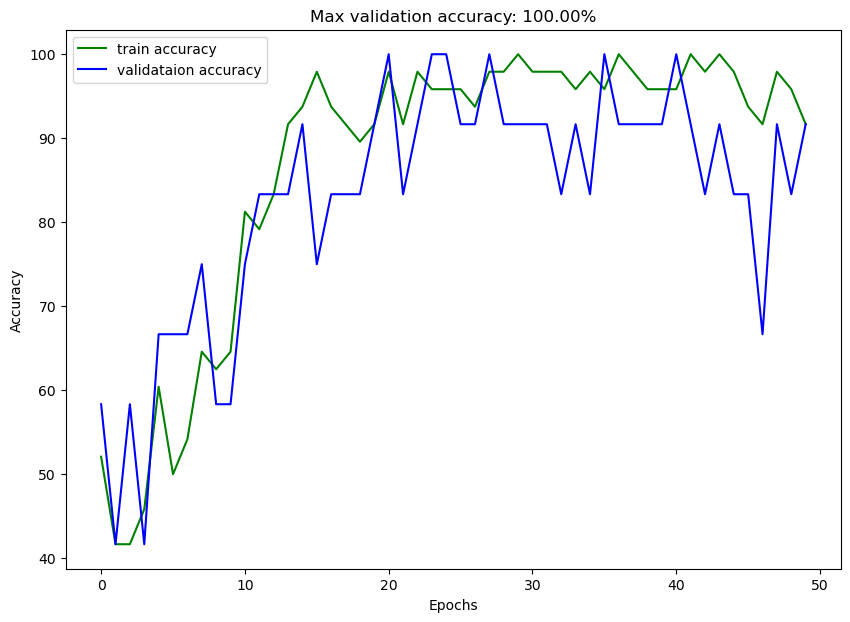

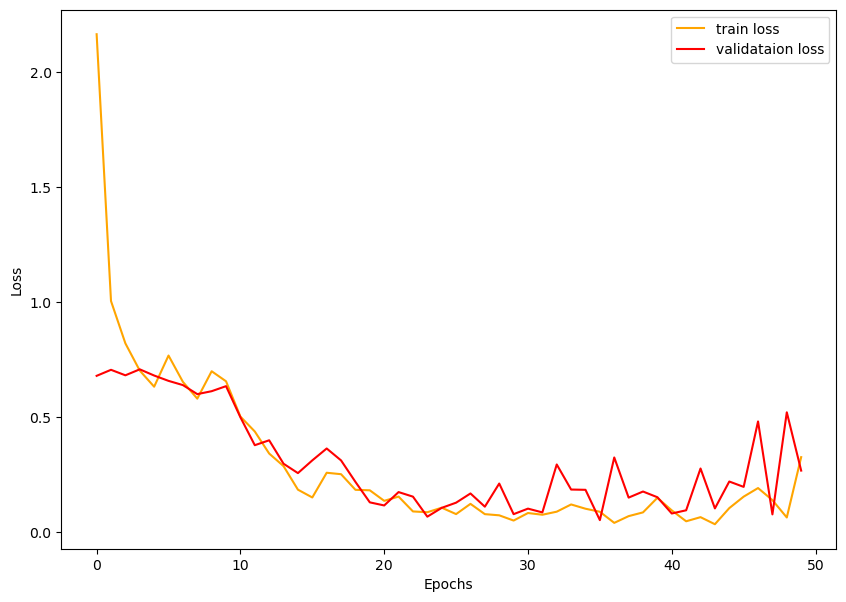

In [26]:
save_model(NUM_EPOCHS, model, optimizer, lossfcn)
save_plots(train_acc, valid_acc, train_loss, valid_loss)

We can also visualize the model performance after training is complete thorugh a confusion matrix. We load in the best model and plot the confusion matrix.

In [27]:
# model, valid_loader, lossfcn
model = CNN(num_classes=train_dataset.num_classes, num_channels=trainimages.shape[1],input_resolution=(num_dirs,num_thresh))

state_dict = torch.load('outputs/best_model.pth')['model_state_dict']
model.load_state_dict(state_dict)
model.eval()
model = model.to(device)
print('Using validation to compute confusion matrix')
valid_running_pred = []
valid_running_labels = []
counter = 0
with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader), total=len(test_loader)):
        counter += 1
        
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        # forward pass
        outputs = model(image)
        # calculate the accuracy
        _, preds = torch.max(outputs.data, 1)

        valid_running_pred.append(preds)
        valid_running_labels.append(labels)
    
# confusion matrix for the complete epoch
valid_running_pred = torch.cat(valid_running_pred)
valid_running_labels = torch.cat(valid_running_labels)
print('classes:',test_dataset.classes)
save_cf(valid_running_pred,valid_running_labels, test_dataset.classes)

C:\Users\manki\AppData\Local\Temp\ipykernel_38528\1193690708.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('outputs/best_model.pth')['model_sta

Using validation to compute confusion matrix


  0%|          | 0/3 [00:00<?, ?it/s]


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same